# import the libraries

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from PIL import Image
import seaborn as sns
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [2]:
path = '/content/drive/MyDrive/Classification/images/Micro_Organism'

class_name = os.listdir(path)
class_length = len(class_name)

print(f"class_length : {class_length}")
print(f"class_name : {class_name}")

class_length : 8
class_name : ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [3]:
class_dis = []
for name in class_name:
  class_dis.append(len(os.listdir(path + "/" + name)))
class_dis

[72, 168, 76, 152, 85, 86, 75, 75]

In [4]:
fig = px.pie(names=class_name, values=class_dis, title='micro organism disribution')
fig.update_layout({'title':{'x':0.45}})
fig.show()

([<matplotlib.patches.Wedge at 0x7fe8a41a2b50>,
 [Text(1.0551051100817352, 0.3110517749176328, 'Amoeba'),
  Text(0.35487919654261557, 1.0411823835722864, 'Euglena'),
  Text(-0.6596038296593472, 0.8802969884639632, 'Hydra'),
  Text(-1.0997820112156762, 0.021898123353443665, 'Paramecium'),
  Text(-0.6631037012630239, -0.8776636493391295, 'Rod_bacteria'),
  Text(0.037222131022199914, -1.0993700527857606, 'Spherical_bacteria'),
  Text(0.6873053328746891, -0.8588430470126733, 'Spiral_bacteria'),
  Text(1.0513143312832172, -0.32363278084662866, 'Yeast')])

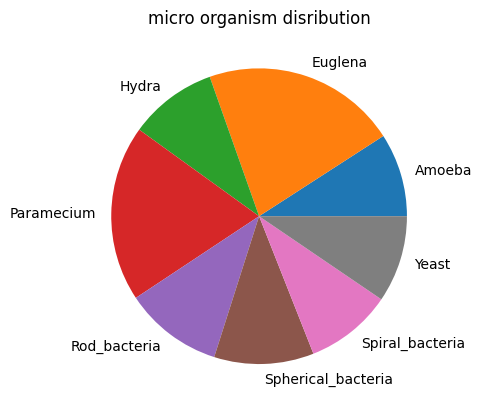

In [5]:
x = class_dis
name = class_name
plt.title("micro organism disribution")
plt.pie(x, labels = name)

In [6]:
# Now we will plot barchart
fig = px.bar(x=class_name, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

<BarContainer object of 8 artists>

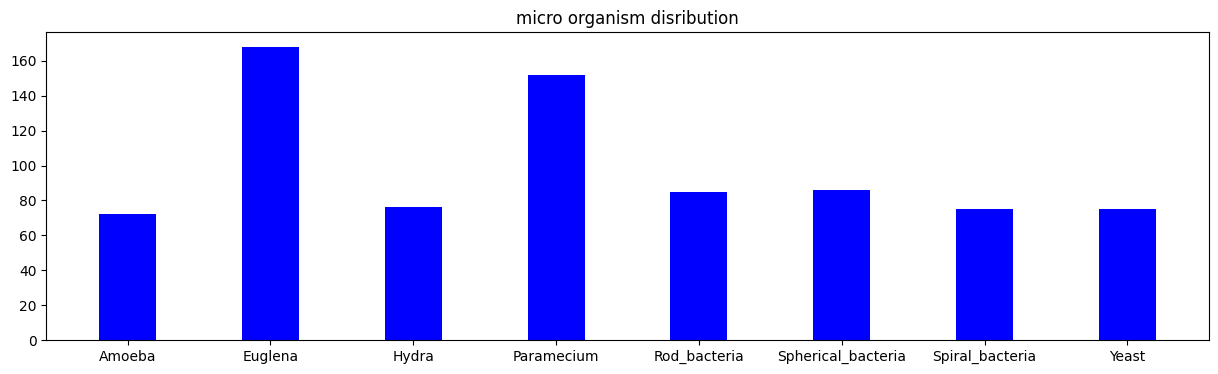

In [7]:
plt.figure(figsize=(15,4))
plt.title("micro organism disribution")
plt.bar(name, class_dis, color ='blue',width = 0.4)

<p>->
Here all the categories has not equal destribution of data. This can be lead the model training in the bised on highly populated categories. So we have to fix it.<br>->
We will use Image data generator to fix it. 
</p>

# Data Augmantation

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

In [9]:
train_ds = datagen.flow_from_directory(
    path,
    batch_size=128,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='training'
)

Found 714 images belonging to 8 classes.


In [10]:
valid_ds = datagen.flow_from_directory(
    path,
    batch_size=64,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='validation'
)

Found 75 images belonging to 8 classes.


# visulization of the data

In [11]:
from numpy.random.mtrand import randint
def show_images(data, GRID=[2,6], model=None, size=(23,10)):
  n_rows, n_cols = GRID
  n_images = n_rows * n_cols
  plt.figure(figsize=size)
  
  images, labels = next(iter(data))

  for i in range(1, n_images+1):
    id = np.random.randint(len(images))
    image, label = images[id], class_name[int(labels[id])]

    plt.subplot(n_rows, n_cols, i)
    plt.imshow(image)
    plt.axis('off')

    if model is not None:
      pred = class_name[np.argmax(model.predict(image[np.newaxis, ...]))]
      title = f"Class : {label} \n Pred : {pred}"
    else:
      title = f"{label}"
      plt.title(title)

  plt.show()

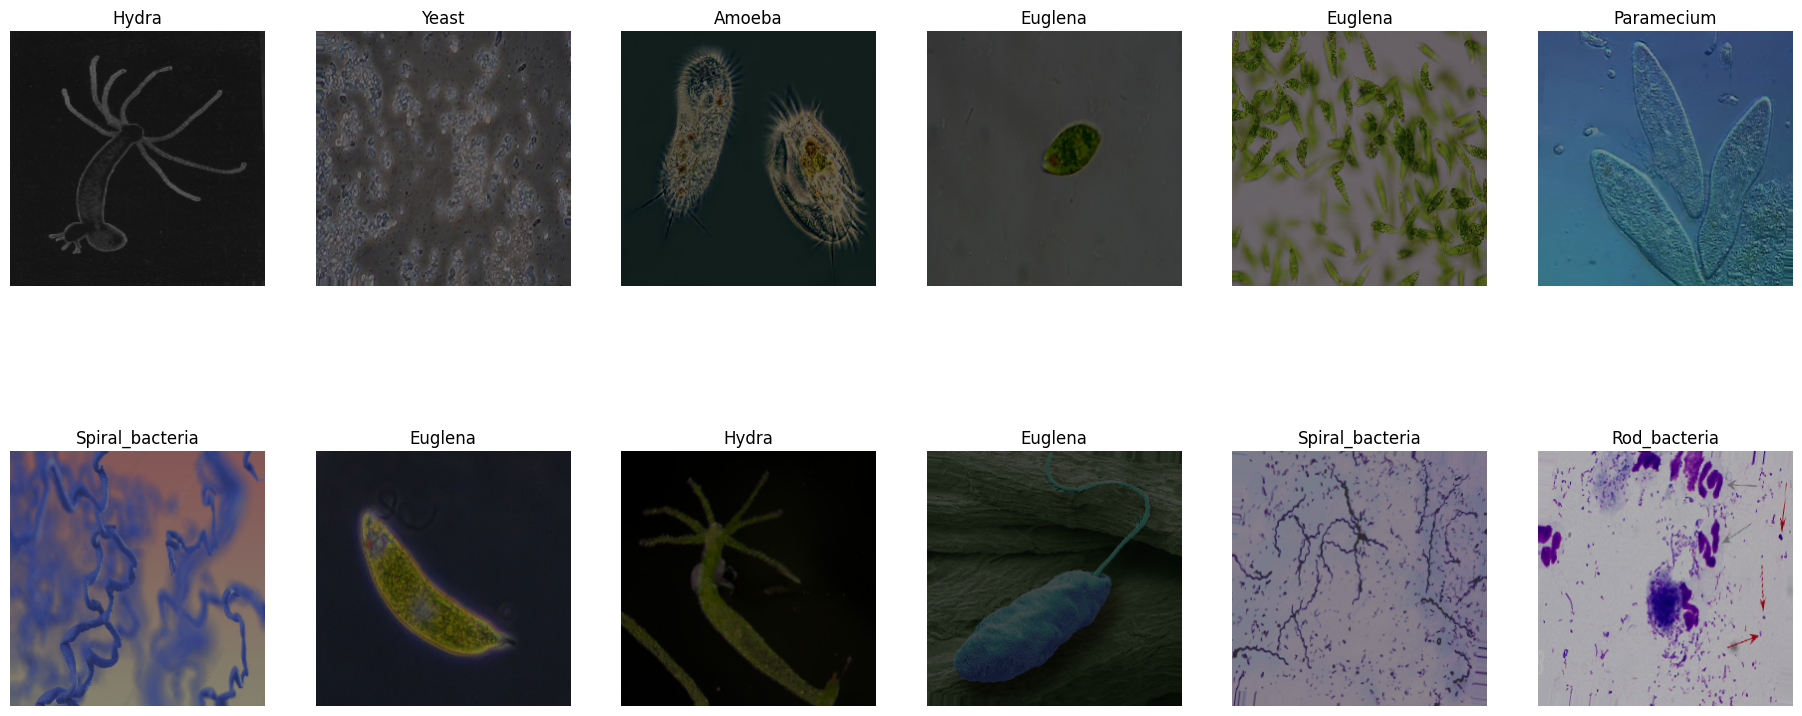

In [12]:
show_images(data=train_ds)